# ML for photo editing 

## Existing products

https://topazlabs.com/adjust-ai/

https://photolemur.com/ - it seems like an app simillar to adjust AI

https://www.meero.com/en/technology

https://prisma-ai.com/

https://skylum.com/luminar

https://www.pixelmator.com/pro/machine-learning/

# Papers and ideas

https://blog.photoeditorsdk.com/deep-learning-for-photo-editing-943bdf9765e1
These guys are using user clicks and object classification to create accurate masks for foreground objects and make them pop

https://www.researchgate.net/publication/269997600_Automatic_Photo_Adjustment_Using_Deep_Neural_Networks
A nice paper with source code. Object classification + set of training images lead to generating both global and local enhancements

https://medium.com/mlreview/making-ai-art-with-style-transfer-using-keras-8bb5fa44b216
Cool description of a style transfer ML, although the maths is pretty crazy

In [1]:
from PIL import Image
import glob
import requests
from io import BytesIO
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
from sklearn.model_selection import train_test_split
import pandas as pd

# Idea 1: Using xmp files for automated image transform 
It turns out that the xmp format isn't really readable, and the only parser for darktable seems to be https://github.com/wmakeev/darkroom-xmp-tools. It'a js wrapper, but it's written in C, so it might be possible to rewrite. However this feels like an extremely complicated solution to a simple problem

In [2]:
darktableCli = "/Applications/darktable.app/Contents/MacOS/darktable-cli"

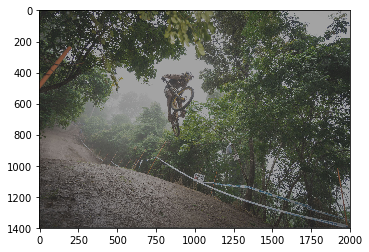

In [3]:
image = Image.open("image.jpg")
plt.imshow(image)

In [4]:
def modifyImageWithXmp(img, xmp):
    img.save("tmp.jpg")
    with open("tmp.xmp", "w") as f: 
        f.write(xmp) 
    process = subprocess.Popen([darktableCli, 'tmp.jpg', 'tmp.xmp','tmpResult.jpg'])
    while True:
        return_code = process.poll()
        if return_code is not None:
            break
    return Image.open("tmpResult.jpg")

In [5]:
!cat image.jpg.xmp

cat: image.jpg.xmp: No such file or directory


In [6]:
with open("image.jpg.xmp", "r") as file:
    sampleXmp = file.read()
image = modifyImageWithXmp(image, sampleXmp)
plt.imshow(image)

FileNotFoundError: [Errno 2] No such file or directory: 'image.jpg.xmp'

# Idea 2: LUTs

In [7]:
# from https://www.programcreek.com/python/example/89460/cv2.LUT
def adjust_brightness(img, brightness_factor):
    """Adjust brightness of an Image.
    Args:
        img (numpy ndarray): numpy ndarray to be adjusted.
        brightness_factor (float):  How much to adjust the brightness. Can be
            any non negative number. 0 gives a black image, 1 gives the
            original image while 2 increases the brightness by a factor of 2.
    Returns:
        numpy ndarray: Brightness adjusted image.
    """
    table = np.array([ i*brightness_factor for i in range (0,256)]).clip(0,255).astype('uint8')
    # same thing but a bit slower
    # cv2.convertScaleAbs(img, alpha=brightness_factor, beta=0)
    if img.shape[2]==1:
        return cv2.LUT(img, table)[:,:,np.newaxis]
    else:
        return cv2.LUT(img, table) 

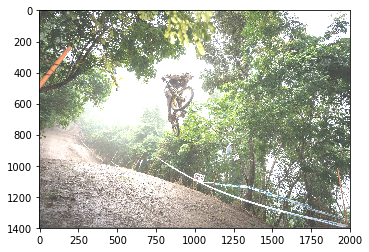

In [8]:
plt.imshow(adjust_brightness(np.array(image), 2))

In [9]:
def applyCustomColorMap(im_gray) :
    
        lut = np.zeros((256, 1, 3), dtype=np.uint8)
    
        #Red channel
        lut[:, 0, 0] = [54,55,56,57,57,58,59,60,61,62,62,63,64,65,66,67,67,68,69,70,71,72,72,73,74,75,76,77,78,78,79,80,81,82,83,83,84,85,86,87,88,88,89,90,91,92,93,93,94,95,96,97,98,98,99,100,101,102,103,103,104,105,106,107,108,110,112,114,116,118,119,121,123,125,127,129,131,133,135,137,139,141,143,145,146,148,150,152,154,156,158,160,162,164,166,168,170,171,173,175,177,179,181,183,185,187,189,191,193,195,197,198,200,202,204,206,208,210,212,214,216,218,220,222,224,225,227,229,230,231,231,232,232,232,233,233,234,234,234,235,235,236,236,236,237,237,238,238,238,239,239,240,240,240,241,241,242,242,242,243,243,244,244,244,245,245,246,246,246,247,247,248,248,248,249,249,250,250,250,251,251,252,252,252,253,253,254,254,254,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255]
        
        #Green channel
        lut[:, 0, 1] = [55,56,56,57,58,59,59,60,61,62,63,63,64,65,66,66,67,68,69,69,70,71,72,72,73,74,75,75,76,77,78,79,79,80,81,82,82,83,84,85,85,86,87,88,88,89,90,91,92,92,93,94,95,95,96,97,98,98,99,100,101,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,166,166,166,166,166,166,166,166,166,166,166,166,166,166,166,166,166,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,164,162,161,160,158,157,156,154,153,152,150,149,148,146,145,144,142,141,140,138,137,136,134,133,132,130,129,128,126,125,124,122,121,120,118,117,116,114,113,112,110,109,108,106,105,104,102,101,100,98,97,96,94,93,92,90,89,88,86,85,84,82,81,80]
    
        #Blue channel
        lut[:, 0, 2] = [54,55,56,56,57,58,59,60,60,61,62,63,64,64,65,66,67,67,68,69,70,71,71,72,73,74,75,75,76,77,78,79,79,80,81,82,82,83,84,85,86,86,87,88,89,90,90,91,92,93,93,94,95,96,97,97,98,99,100,101,101,102,103,104,104,105,105,105,105,105,105,106,106,106,106,106,106,107,107,107,107,107,107,108,108,108,108,108,108,109,109,109,109,109,109,110,110,110,110,110,110,111,111,111,111,111,111,112,112,112,112,112,113,113,113,113,113,113,114,114,114,114,114,114,115,115,115,115,115,115,115,116,116,116,116,116,116,116,117,117,117,117,117,117,117,117,118,118,118,118,118,118,118,119,119,119,119,119,119,119,119,120,120,120,120,120,120,120,121,121,121,121,121,121,121,121,122,122,122,122,122,122,122,123,123,123,123,123,123,123,123,124,122,120,118,116,114,112,111,109,107,105,103,101,99,97,95,93,91,89,87,85,83,81,80,78,76,74,72,70,68,66,64,62,60,58,56,54,52,50,48,47,45,43,41,39,37,35,33,31,29,27,25,23,21,19,17,16,14,12,10,8,6,4,2,0]
    
    
        im_color = cv2.LUT(im_gray, lut)
    
        return im_color; 

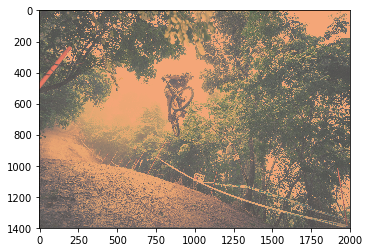

In [10]:
plt.imshow(applyCustomColorMap(np.array(image)))

# It seems that we can replicate most transforms using LUTs... 
What if we were to pose a problem of:
    For a given photo, create a LUT that makes it look in a particular style/makes it look pretty.

# Some more ideas
Using already corrected photos from free stock sites

Using #nofilter photos and finding similar but corrected photos

In [11]:
image_list = []
for filename in glob.glob('samples/unsplash/*.jpg'):
    im=Image.open(filename)
    image_list.append(im)

In [12]:
def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

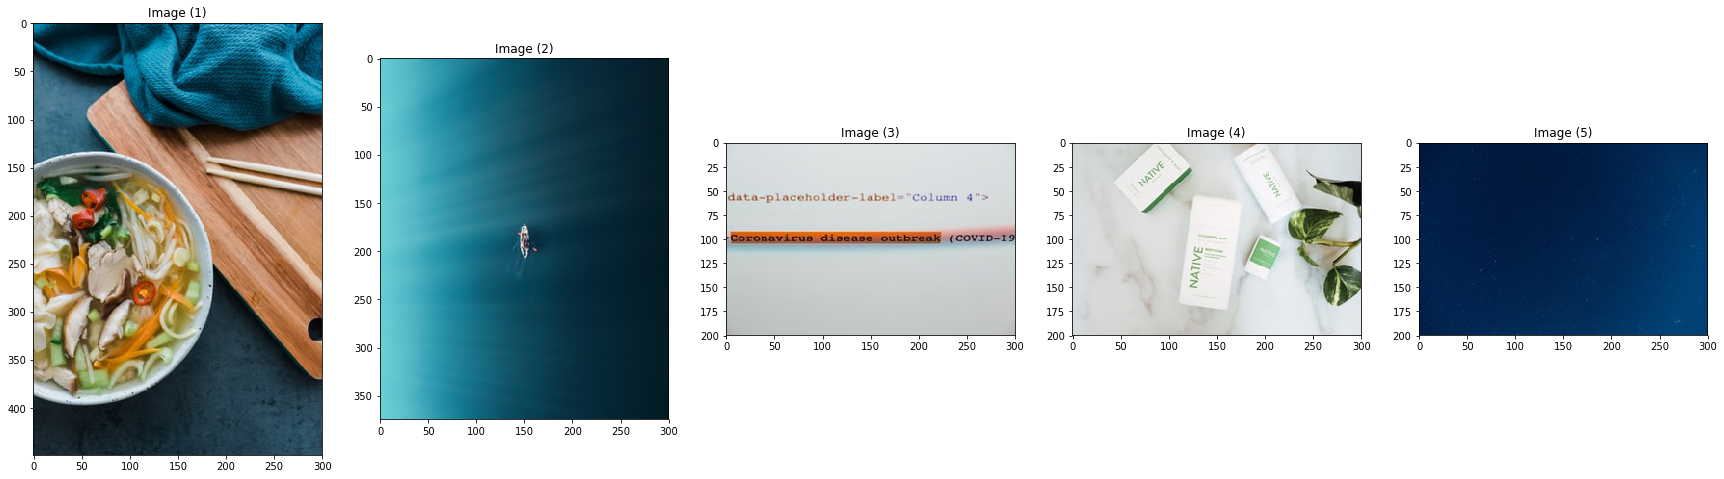

In [13]:
show_images(list(map(lambda x: np.array(x),image_list[0:5])))

# let's randomise their brightness

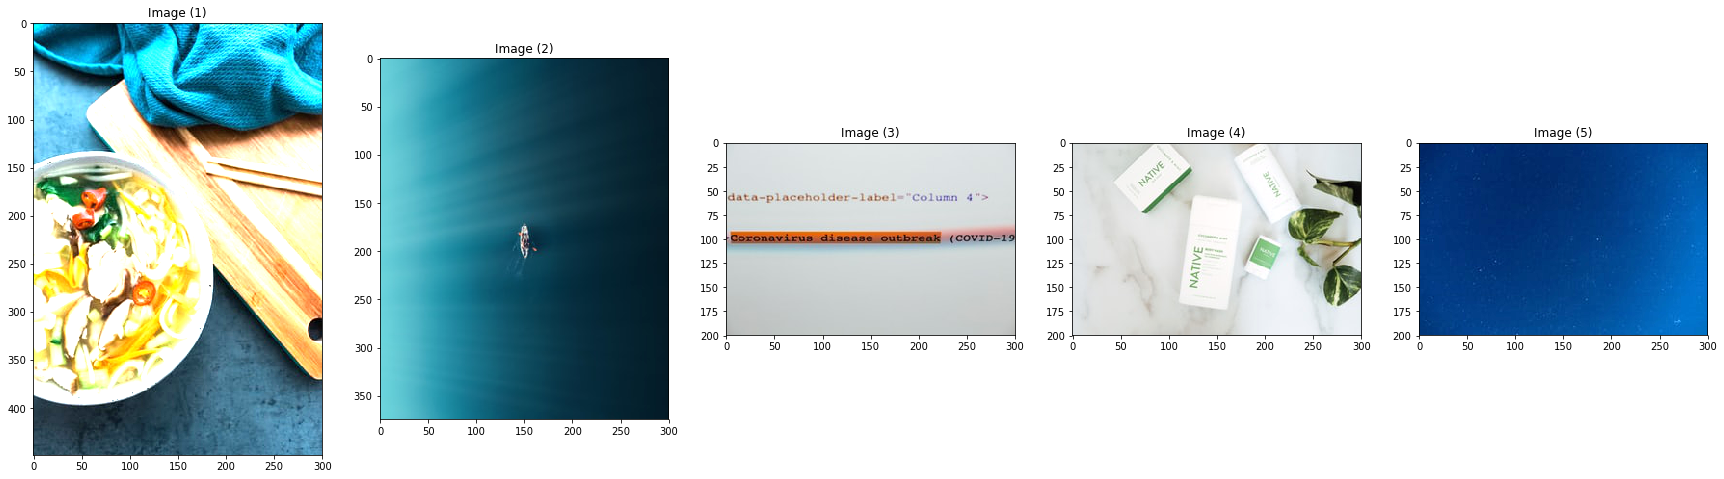

In [14]:
images = list(map(lambda image: np.array(adjust_brightness(np.array(image), 1+random.uniform(-1,1))), image_list))
show_images(images[0:5])

# what if we train our NN on how well it can approximate the original image given a randomised one?

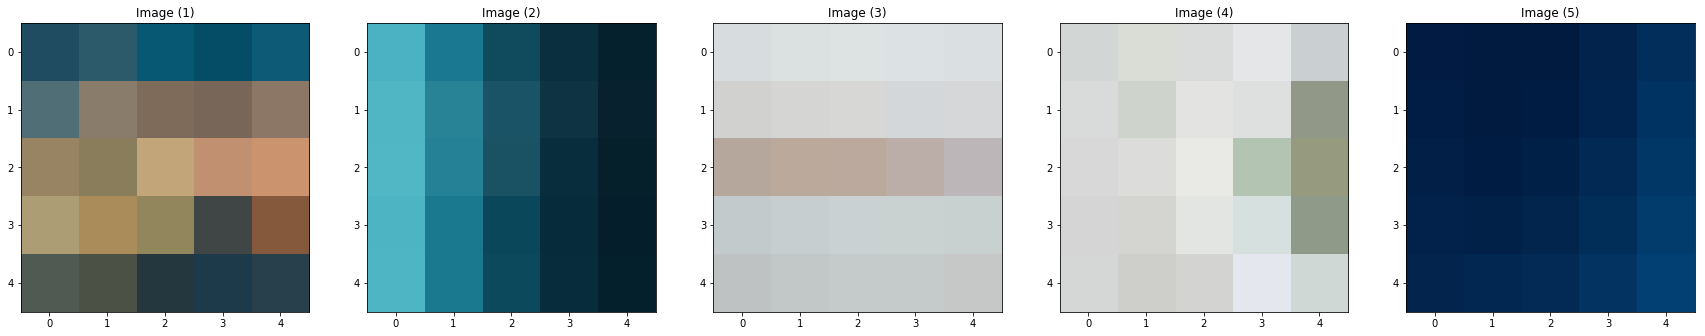

In [15]:
resized_images = list(map(lambda x: np.array(x.resize((5,5), resample=Image.BICUBIC)),image_list))
show_images(resized_images[0:5])

In [16]:
features = []
labels=[]
for image in resized_images:
    for sample in range(50):
        brightness = random.uniform(-1,1)
        features.append(adjust_brightness(image, 1+brightness))
        labels.append(brightness)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

In [18]:
len(X_train)

6880

In [19]:
len(X_test)

1720

In [20]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [21]:
model = keras.Sequential([
layers.Dense(32, activation='relu', input_shape=[5,5,3]),
layers.Conv2D(3,5, activation='relu'),
layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=0.01)

model.compile(loss='mean_absolute_error',
            optimizer=optimizer)

Instructions for updating:
Colocations handled automatically by placer.


In [22]:
print(model.input_shape)
print(model.output_shape)

(None, 5, 5, 3)
(None, 1, 1, 1)


In [23]:
EPOCHS = 1000
model.fit(
  np.array(X_train), np.array(y_train),
  epochs=EPOCHS, validation_split = 0.2)

Train on 5504 samples, validate on 1376 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
5504/5504 [==============================] - 1s 161us/sample - loss: 18.4468 - val_loss: 16.0943
Epoch 2/1000
5504/5504 [==============================] - 1s 97us/sample - loss: 16.0006 - val_loss: 16.0812
Epoch 3/1000
5504/5504 [==============================] - 1s 136us/sample - loss: 16.0151 - val_loss: 16.0848
Epoch 4/1000
5504/5504 [==============================] - 1s 97us/sample - loss: 15.9919 - val_loss: 16.0825
Epoch 5/1000
5504/5504 [==============================] - 0s 69us/sample - loss: 15.9879 - val_loss: 16.0768
Epoch 6/1000
5504/5504 [==============================] - 0s 66us/sample - loss: 15.9973 - val_loss: 16.0470
Epoch 7/1000
5504/5504 [==============================] - 1s 92us/sample - loss: 15.9864 - val_loss: 16.1012
Epoch 8/1000
5504/5504 [==============================] - 1s 155us/sample - loss: 15.9867 - val_loss: 16.1499
Epoch 9/1000
5504/5504 [=====

5504/5504 [==============================] - 0s 46us/sample - loss: 15.9846 - val_loss: 16.1770
Epoch 73/1000
5504/5504 [==============================] - 0s 80us/sample - loss: 16.0056 - val_loss: 16.0478
Epoch 74/1000
5504/5504 [==============================] - 0s 60us/sample - loss: 15.9957 - val_loss: 16.0555
Epoch 75/1000
5504/5504 [==============================] - 0s 67us/sample - loss: 15.9900 - val_loss: 16.0636
Epoch 76/1000
5504/5504 [==============================] - 0s 88us/sample - loss: 16.0036 - val_loss: 16.0713
Epoch 77/1000
5504/5504 [==============================] - 0s 75us/sample - loss: 15.9946 - val_loss: 16.1633
Epoch 78/1000
5504/5504 [==============================] - 0s 56us/sample - loss: 16.0005 - val_loss: 16.0558
Epoch 79/1000
5504/5504 [==============================] - 0s 50us/sample - loss: 16.0131 - val_loss: 16.1009
Epoch 80/1000
5504/5504 [==============================] - 0s 57us/sample - loss: 15.9998 - val_loss: 16.0897
Epoch 81/1000
5504/5504 

5504/5504 [==============================] - 0s 59us/sample - loss: 15.9931 - val_loss: 16.0792
Epoch 147/1000
5504/5504 [==============================] - 0s 69us/sample - loss: 15.9952 - val_loss: 16.0816
Epoch 148/1000
5504/5504 [==============================] - 0s 58us/sample - loss: 15.9873 - val_loss: 16.0489
Epoch 149/1000
5504/5504 [==============================] - 1s 171us/sample - loss: 15.9870 - val_loss: 16.0498
Epoch 150/1000
5504/5504 [==============================] - 1s 133us/sample - loss: 15.9948 - val_loss: 16.0986
Epoch 151/1000
5504/5504 [==============================] - 0s 74us/sample - loss: 15.9918 - val_loss: 16.0978
Epoch 152/1000
5504/5504 [==============================] - 0s 63us/sample - loss: 15.9962 - val_loss: 16.0844
Epoch 153/1000
5504/5504 [==============================] - 0s 55us/sample - loss: 16.0108 - val_loss: 16.0622
Epoch 154/1000
5504/5504 [==============================] - 0s 86us/sample - loss: 15.9899 - val_loss: 16.0559
Epoch 155/1000

Epoch 220/1000
5504/5504 [==============================] - 0s 49us/sample - loss: 16.0044 - val_loss: 16.0931
Epoch 221/1000
5504/5504 [==============================] - 0s 54us/sample - loss: 15.9907 - val_loss: 16.2063
Epoch 222/1000
5504/5504 [==============================] - 0s 54us/sample - loss: 15.9875 - val_loss: 16.2171
Epoch 223/1000
5504/5504 [==============================] - 0s 55us/sample - loss: 15.9945 - val_loss: 16.1422
Epoch 224/1000
5504/5504 [==============================] - 0s 52us/sample - loss: 15.9969 - val_loss: 16.0711
Epoch 225/1000
5504/5504 [==============================] - 0s 51us/sample - loss: 15.9941 - val_loss: 16.0492
Epoch 226/1000
5504/5504 [==============================] - 0s 55us/sample - loss: 15.9903 - val_loss: 16.0878
Epoch 227/1000
5504/5504 [==============================] - 0s 49us/sample - loss: 15.9941 - val_loss: 16.1739
Epoch 228/1000
5504/5504 [==============================] - 0s 52us/sample - loss: 15.9957 - val_loss: 16.0674
E

Epoch 294/1000
5504/5504 [==============================] - 0s 57us/sample - loss: 15.9892 - val_loss: 16.0520
Epoch 295/1000
5504/5504 [==============================] - 0s 50us/sample - loss: 15.9985 - val_loss: 16.0651
Epoch 296/1000
5504/5504 [==============================] - 0s 54us/sample - loss: 15.9944 - val_loss: 16.0520
Epoch 297/1000
5504/5504 [==============================] - 0s 58us/sample - loss: 15.9996 - val_loss: 16.0555
Epoch 298/1000
5504/5504 [==============================] - 0s 50us/sample - loss: 15.9982 - val_loss: 16.1541
Epoch 299/1000
5504/5504 [==============================] - 0s 52us/sample - loss: 15.9885 - val_loss: 16.1074
Epoch 300/1000
5504/5504 [==============================] - 0s 53us/sample - loss: 15.9906 - val_loss: 16.0742
Epoch 301/1000
5504/5504 [==============================] - 0s 52us/sample - loss: 15.9969 - val_loss: 16.0473
Epoch 302/1000
5504/5504 [==============================] - 0s 52us/sample - loss: 15.9945 - val_loss: 16.0977
E

Epoch 368/1000
5504/5504 [==============================] - 0s 54us/sample - loss: 15.9873 - val_loss: 16.0569
Epoch 369/1000
5504/5504 [==============================] - 0s 50us/sample - loss: 15.9865 - val_loss: 16.1150
Epoch 370/1000
5504/5504 [==============================] - 0s 53us/sample - loss: 15.9974 - val_loss: 16.0961
Epoch 371/1000
5504/5504 [==============================] - 0s 54us/sample - loss: 15.9975 - val_loss: 16.0549
Epoch 372/1000
5504/5504 [==============================] - 0s 51us/sample - loss: 15.9957 - val_loss: 16.0551
Epoch 373/1000
5504/5504 [==============================] - 0s 53us/sample - loss: 15.9912 - val_loss: 16.0496
Epoch 374/1000
5504/5504 [==============================] - 0s 58us/sample - loss: 15.9859 - val_loss: 16.0502
Epoch 375/1000
5504/5504 [==============================] - 0s 82us/sample - loss: 15.9928 - val_loss: 16.0478
Epoch 376/1000
5504/5504 [==============================] - 0s 67us/sample - loss: 15.9924 - val_loss: 16.0643
E

5504/5504 [==============================] - 0s 66us/sample - loss: 16.0097 - val_loss: 16.0568
Epoch 442/1000
5504/5504 [==============================] - 0s 57us/sample - loss: 15.9946 - val_loss: 16.0643
Epoch 443/1000
5504/5504 [==============================] - 0s 87us/sample - loss: 16.0093 - val_loss: 16.0874
Epoch 444/1000
5504/5504 [==============================] - 1s 108us/sample - loss: 15.9979 - val_loss: 16.0701
Epoch 445/1000
5504/5504 [==============================] - 1s 120us/sample - loss: 15.9869 - val_loss: 16.0501
Epoch 446/1000
5504/5504 [==============================] - 1s 107us/sample - loss: 15.9998 - val_loss: 16.0754
Epoch 447/1000
5504/5504 [==============================] - 0s 56us/sample - loss: 15.9945 - val_loss: 16.0647
Epoch 448/1000
5504/5504 [==============================] - 0s 58us/sample - loss: 15.9879 - val_loss: 16.1547
Epoch 449/1000
5504/5504 [==============================] - 0s 49us/sample - loss: 15.9959 - val_loss: 16.1071
Epoch 450/100

5504/5504 [==============================] - 0s 48us/sample - loss: 15.9855 - val_loss: 16.0490
Epoch 515/1000
5504/5504 [==============================] - 0s 50us/sample - loss: 15.9930 - val_loss: 16.1682
Epoch 516/1000
5504/5504 [==============================] - 0s 48us/sample - loss: 15.9830 - val_loss: 16.0468
Epoch 517/1000
5504/5504 [==============================] - 0s 47us/sample - loss: 15.9843 - val_loss: 16.1686
Epoch 518/1000
5504/5504 [==============================] - 0s 47us/sample - loss: 15.9959 - val_loss: 16.1096
Epoch 519/1000
5504/5504 [==============================] - 0s 66us/sample - loss: 15.9924 - val_loss: 16.0843
Epoch 520/1000
5504/5504 [==============================] - 0s 54us/sample - loss: 15.9991 - val_loss: 16.0782
Epoch 521/1000
5504/5504 [==============================] - 0s 48us/sample - loss: 15.9938 - val_loss: 16.0913
Epoch 522/1000
5504/5504 [==============================] - 0s 46us/sample - loss: 15.9866 - val_loss: 16.0708
Epoch 523/1000
5

Epoch 588/1000
5504/5504 [==============================] - 0s 46us/sample - loss: 15.9921 - val_loss: 16.0631
Epoch 589/1000
5504/5504 [==============================] - 0s 47us/sample - loss: 15.9909 - val_loss: 16.0482
Epoch 590/1000
5504/5504 [==============================] - 0s 46us/sample - loss: 15.9903 - val_loss: 16.0808
Epoch 591/1000
5504/5504 [==============================] - 0s 47us/sample - loss: 16.0062 - val_loss: 16.1881
Epoch 592/1000
5504/5504 [==============================] - 0s 46us/sample - loss: 15.9911 - val_loss: 16.1567
Epoch 593/1000
5504/5504 [==============================] - 0s 46us/sample - loss: 15.9989 - val_loss: 16.0582
Epoch 594/1000
5504/5504 [==============================] - 0s 91us/sample - loss: 15.9854 - val_loss: 16.1881
Epoch 595/1000
5504/5504 [==============================] - 0s 79us/sample - loss: 16.0052 - val_loss: 16.0708
Epoch 596/1000
5504/5504 [==============================] - 1s 212us/sample - loss: 16.0034 - val_loss: 16.0477


5504/5504 [==============================] - 0s 85us/sample - loss: 15.9969 - val_loss: 16.1206
Epoch 662/1000
5504/5504 [==============================] - 1s 102us/sample - loss: 16.0006 - val_loss: 16.1070
Epoch 663/1000
5504/5504 [==============================] - 0s 76us/sample - loss: 15.9927 - val_loss: 16.0509
Epoch 664/1000
5504/5504 [==============================] - 1s 106us/sample - loss: 15.9953 - val_loss: 16.0846
Epoch 665/1000
5504/5504 [==============================] - 0s 88us/sample - loss: 15.9988 - val_loss: 16.0788
Epoch 666/1000
5504/5504 [==============================] - 0s 79us/sample - loss: 15.9914 - val_loss: 16.1658
Epoch 667/1000
5504/5504 [==============================] - 0s 91us/sample - loss: 16.0013 - val_loss: 16.1105
Epoch 668/1000
5504/5504 [==============================] - 1s 109us/sample - loss: 15.9886 - val_loss: 16.0900
Epoch 669/1000
5504/5504 [==============================] - 1s 100us/sample - loss: 15.9879 - val_loss: 16.0626
Epoch 670/10

5504/5504 [==============================] - 1s 110us/sample - loss: 15.9979 - val_loss: 16.1130
Epoch 735/1000
5504/5504 [==============================] - 0s 66us/sample - loss: 15.9920 - val_loss: 16.0622
Epoch 736/1000
5504/5504 [==============================] - 0s 61us/sample - loss: 15.9975 - val_loss: 16.0533
Epoch 737/1000
5504/5504 [==============================] - 0s 58us/sample - loss: 15.9915 - val_loss: 16.0637
Epoch 738/1000
5504/5504 [==============================] - 0s 51us/sample - loss: 15.9714 - val_loss: 16.2737
Epoch 739/1000
5504/5504 [==============================] - 0s 58us/sample - loss: 16.0127 - val_loss: 16.1561
Epoch 740/1000
5504/5504 [==============================] - 0s 56us/sample - loss: 15.9902 - val_loss: 16.1607
Epoch 741/1000
5504/5504 [==============================] - 0s 55us/sample - loss: 16.0027 - val_loss: 16.1746
Epoch 742/1000
5504/5504 [==============================] - 0s 53us/sample - loss: 15.9856 - val_loss: 16.0558
Epoch 743/1000


Epoch 808/1000
5504/5504 [==============================] - 0s 53us/sample - loss: 15.9916 - val_loss: 16.1310
Epoch 809/1000
5504/5504 [==============================] - 0s 50us/sample - loss: 15.9866 - val_loss: 16.0486
Epoch 810/1000
5504/5504 [==============================] - 0s 51us/sample - loss: 16.0029 - val_loss: 16.0984
Epoch 811/1000
5504/5504 [==============================] - 0s 48us/sample - loss: 15.9951 - val_loss: 16.0863
Epoch 812/1000
5504/5504 [==============================] - 0s 50us/sample - loss: 15.9869 - val_loss: 16.0588
Epoch 813/1000
5504/5504 [==============================] - 0s 49us/sample - loss: 16.0030 - val_loss: 16.1510
Epoch 814/1000
5504/5504 [==============================] - 0s 78us/sample - loss: 15.9797 - val_loss: 16.0545
Epoch 815/1000
5504/5504 [==============================] - 0s 75us/sample - loss: 15.9893 - val_loss: 16.1428
Epoch 816/1000
5504/5504 [==============================] - 0s 56us/sample - loss: 15.9845 - val_loss: 16.1494
E

Epoch 882/1000
5504/5504 [==============================] - 0s 68us/sample - loss: 15.9895 - val_loss: 16.0584
Epoch 883/1000
5504/5504 [==============================] - 0s 59us/sample - loss: 15.9908 - val_loss: 16.0854
Epoch 884/1000
5504/5504 [==============================] - 0s 54us/sample - loss: 16.0177 - val_loss: 16.0581
Epoch 885/1000
5504/5504 [==============================] - 0s 54us/sample - loss: 15.9947 - val_loss: 16.0832
Epoch 886/1000
5504/5504 [==============================] - 0s 51us/sample - loss: 15.9979 - val_loss: 16.1478
Epoch 887/1000
5504/5504 [==============================] - 0s 55us/sample - loss: 16.0009 - val_loss: 16.0539
Epoch 888/1000
5504/5504 [==============================] - 0s 64us/sample - loss: 15.9952 - val_loss: 16.2137
Epoch 889/1000
5504/5504 [==============================] - 0s 60us/sample - loss: 15.9997 - val_loss: 16.1122
Epoch 890/1000
5504/5504 [==============================] - 0s 62us/sample - loss: 15.9917 - val_loss: 16.0476
E

5504/5504 [==============================] - 0s 82us/sample - loss: 15.9885 - val_loss: 16.1483
Epoch 956/1000
5504/5504 [==============================] - 0s 66us/sample - loss: 15.9915 - val_loss: 16.0487
Epoch 957/1000
5504/5504 [==============================] - 0s 71us/sample - loss: 15.9964 - val_loss: 16.0809
Epoch 958/1000
5504/5504 [==============================] - 0s 65us/sample - loss: 15.9908 - val_loss: 16.1040
Epoch 959/1000
5504/5504 [==============================] - 1s 107us/sample - loss: 15.9895 - val_loss: 16.0664
Epoch 960/1000
5504/5504 [==============================] - 0s 67us/sample - loss: 15.9807 - val_loss: 16.0476
Epoch 961/1000
5504/5504 [==============================] - 0s 65us/sample - loss: 15.9885 - val_loss: 16.1282
Epoch 962/1000
5504/5504 [==============================] - 0s 62us/sample - loss: 15.9968 - val_loss: 16.1599
Epoch 963/1000
5504/5504 [==============================] - 0s 59us/sample - loss: 15.9894 - val_loss: 16.0567
Epoch 964/1000


In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

NameError: name 'history' is not defined

In [ ]:
predict = model.predict(np.array(X_test))

In [ ]:
predict = predict[:,0,0,0]

In [ ]:
np.array(y_test)

In [ ]:
predict

In [ ]:
results = []
for i,image in enumerate(X_test):
    results.append(adjust_brightness(image, 1-predict[i]))
show_images(results[0:5])

# approach 2

In [ ]:
import colorsys
from sklearn.cluster import KMeans
import ipywidgets as widgets
import matplotlib

In [ ]:
image = image_list[0]
image = image.resize((50,50))
image

In [ ]:
pixels = np.array(image).reshape((image.width * image.height,3))
# pixels = np.array(list(map(lambda c: colorsys.rgb_to_yiq(c[0],c[1],c[2]), pixels)))
pixels

In [ ]:
pixels.shape

In [ ]:
kmeans = KMeans(n_clusters=20)
kmeans.fit(pixels)
colors = kmeans.cluster_centers_
# colors = np.array(list(map(lambda c: colorsys.yiq_to_rgb(c[0],c[1],c[2]), colors)))

In [ ]:
plt.imshow(np.asarray([colors]).astype(int))

In [ ]:
colors = colors[colors[:,2].argsort()] # First sort doesn't need to be stable.
colors = colors[colors[:,1].argsort(kind='mergesort')]
colors = colors[colors[:,0].argsort(kind='mergesort')]
colors

In [ ]:
plt.imshow(np.asarray([colors]).astype(int))

In [ ]:
def getMapForImage(image, clusters=20):
    image = image.resize((50,50))
    pixels = np.array(image).reshape((image.width * image.height,3))
    kmeans = KMeans(n_clusters=clusters)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_
    colors = colors[colors[:,2].argsort()] # First sort doesn't need to be stable.
    colors = colors[colors[:,1].argsort(kind='mergesort')]
    colors = colors[colors[:,0].argsort(kind='mergesort')]
    return np.asarray([colors]).astype(int)

In [ ]:
plt.imshow(getMapForImage(image_list[1]))
image_list[1]

In [ ]:
plt.imshow(getMapForImage(image_list[3],clusters=5))
image = image_list[3].resize((300,200))
image

In [ ]:
colors = getMapForImage(image,clusters=5)[0]
hexcolors = list(map(lambda y: matplotlib.colors.to_hex(list(map(lambda x:x/255,y))),
             colors))
wdg = []

In [ ]:
for color in hexcolors: 
    w = widgets.ColorPicker(
        concise=False,
        description='Pick a color',
        value=color,
        disabled=False
    )
    wdg.append(w)
    display(w)

In [ ]:
changed_colors = list(map(lambda x: (np.array(matplotlib.colors.to_rgb(x.value))*255).astype(int), wdg))

In [ ]:
changed_colors

In [ ]:
def mapColorOverChange(color):
    res = np.zeros((1,3))
    for org, change in zip(colors, changed_colors):
        c1 = np.array(color)
        c2 = np.array(org)
        distance = np.linalg.norm(np.array(colorsys.rgb_to_hls(c1[0],c1[1],c1[2])) - np.array(colorsys.rgb_to_hls(c2[0],c2[1],c2[2])))
        coeff = (distance/200)**2
        res+=  coeff * (np.array(change) - np.array(org))
    return (np.array(color) + res).astype(int)

In [ ]:
mapColorOverChange([255,50,0])

In [ ]:
image = image_list[3]

In [ ]:
arr = np.array(list(map(lambda t:np.array(mapColorOverChange(t[0])), 
                        np.array(image).reshape((image.width * image.height, 1,3)))))


In [ ]:
img_modified = arr.reshape((image.height, image.width, 3))

In [ ]:
plt.imshow(img_modified)

In [ ]:
# lut